In [1]:
import pandas as pd
import os
import sys

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

from matplotlib.ticker import FuncFormatter

In [3]:
labelsize = 18
titlesize = 20

In [4]:
df_times_path = './res/aggregated/default_times.csv'
LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

In [5]:
sys.path.append('..')

In [6]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [7]:
df_times = pd.read_csv(df_times_path, header=0, index_col=0)

trans_df_times = df_times.transpose()

In [8]:
trans_df_times.head()

,17,9,29,26,50,4,5,13,64
0,NaN,NaN,NaN,2.758333,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.780556,NaN,NaN,NaN,NaN,4.6,NaN
2,0.102778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.836111,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
TOTAL_SIM = float(len(trans_df_times))

In [10]:
import numpy as np

maturity = 5.

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [11]:
def str_interval((x, y)):
    arr_str = []
    for xx in (x, y):
        str_xx = str(xx)
        if str_xx[-1] == '0':
            str_xx = str_xx[:-2]
        arr_str.append(str_xx)
        
    return r'$[%s]$' % (', '.join(arr_str))

indx = map(str_interval, zip(times_cva, shifted_times_cva))
cols = ['Percentage of defaults per path', r'$\rm{Expectation}$', r'$\rm{Standard \,\, deviation}$']

df_defaults_losses = pd.DataFrame(index=indx, columns=cols)

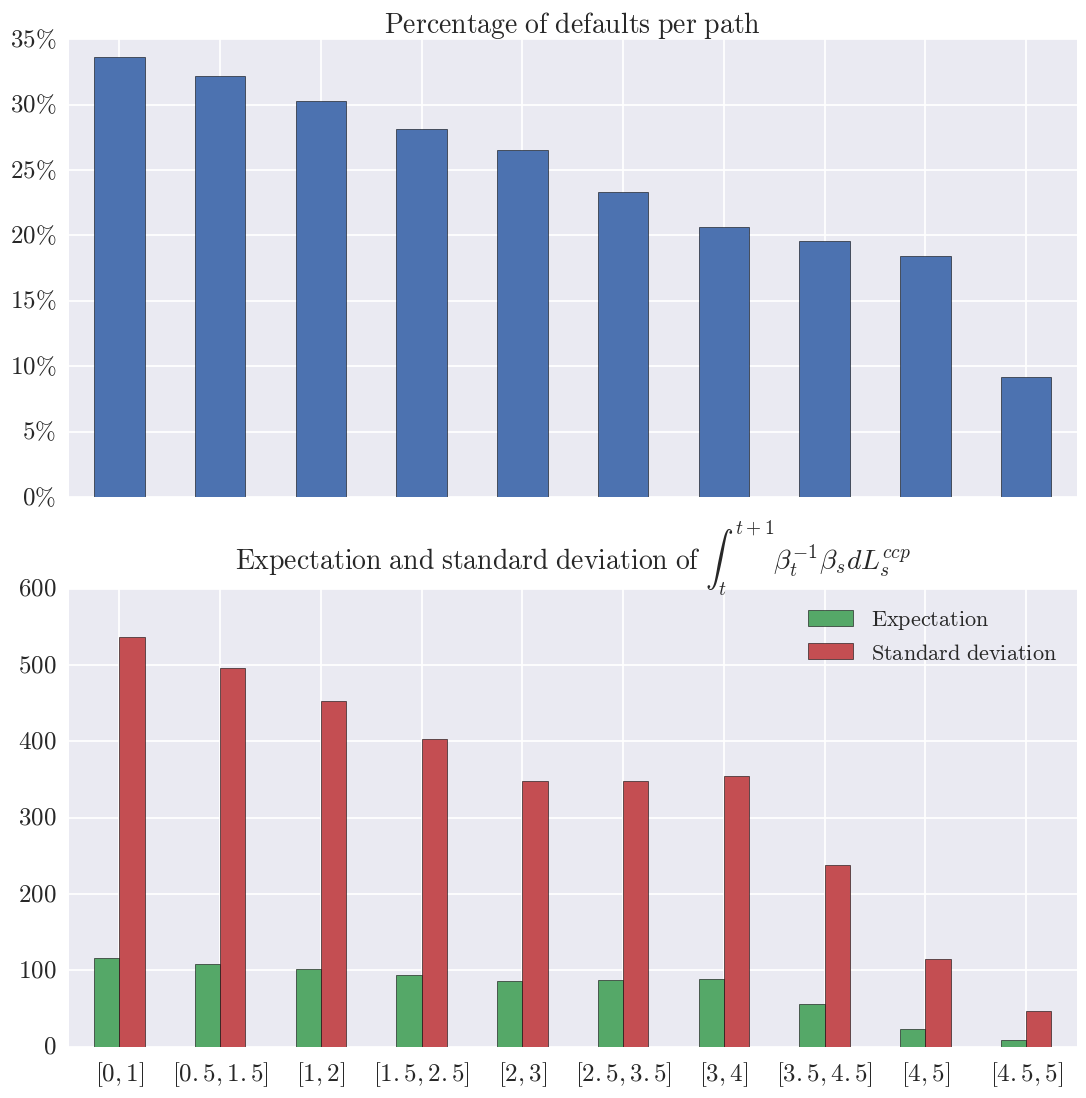

In [12]:
QUANTILE_IM = 0.85
defaults, e_losses, v_losses = [pd.Series(index=indx) for _ in xrange(3)]

for t0, t1 in zip(times_cva, shifted_times_cva):
    key = str_interval((t0, t1))
    index = (t0 <= trans_df_times) & (trans_df_times < t1)
    
    # Defaults
    crt_df_defaults = trans_df_times[index]
    crt_df_defaults = crt_df_defaults.dropna(how='all')
    
    crt_df_defaults['sum'] = crt_df_defaults.count(axis=1, numeric_only=True)
    nb = crt_df_defaults['sum'].sum()
    
    defaults[key] = nb / TOTAL_SIM
    
    # Losses
    str_int = '[%.2f, %.2f]' % (t0, t1)
    fname = 'loim_%s_%s.csv' % (str_int, QUANTILE_IM)
    loim_q_path = os.path.join(LOIM_PATH, fname)
    loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
    fname = '%s/cva_%.2f.csv' % (QUANTILE_IM, t0)
    cva_q_path_t0 = os.path.join(CVA_PATH, fname)
    cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
    fname = '%s/cva_%.2f.csv' % (QUANTILE_IM, t1)
    cva_q_path_t1 = os.path.join(CVA_PATH, fname)
    cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
    
    all_loss = loim_df.sum(axis=1) + (discount(t1) * cva_t1_df.sum(axis=1)) - (discount(t0) * cva_t0_df.sum(axis=1))
    all_loss = all_loss / discount(t0)
    
    index2 = index.loc[index.any(axis=1)].index.values
    index2 = map(int, index2)
    
    loss = all_loss[index2]
    
    e_losses[key] = loss.mean()
    v_losses[key] = loss.std()
    
df_defaults_losses['Percentage of defaults per path'] = defaults
df_defaults_losses[r'$\rm{Expectation}$'] = e_losses
df_defaults_losses[r'$\rm{Standard \,\, deviation}$'] = v_losses

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 13), sharex=True)

formatter_pct = lambda x, pos: r'$%.0f \%%$' % (x * 100)
formatter_pct = FuncFormatter(formatter_pct)

df_defaults_losses['Percentage of defaults per path'].plot.bar(ax=ax1, rot=0, use_index=False)
ax1.set_title(r'$\rm{Percentage \,\,  of \,\, defaults \,\, per \,\, path}$', fontsize=titlesize)

ax1.yaxis.set_major_formatter(formatter_pct)

df_defaults_losses.drop('Percentage of defaults per path', axis=1, inplace=True)
df_defaults_losses.plot.bar(ax=ax2, color=sns.color_palette()[1:4], rot=0)

formatter_bps = FuncFormatter(lambda y, pos: r'$%.0f$' % (y * 10000.))

ax2.yaxis.set_major_formatter(formatter_bps)
ax2.set_title(r'$\rm{Expectation \,\, and \,\, standard \,\, deviation \,\, of \,\,}$'
              r'$\int_t^{t+1} \beta_t^{-1} \beta_s d L_s^{ccp}}$',
              y=1.03, 
              fontsize=titlesize)

ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.legend(fontsize=labelsize-2)

plt.show()